In [2]:
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma

In [3]:
# To supress the scientific notation for easier reading.
np.set_printoptions(suppress=True)

# Test Development

In developing the code, three main tests have been completed within one region: Amhara. The first at a very micro level with a custom dummy dataset with only two primary schools and 2 proposed secondary schools. The second is for one woreda/district with 21 primary schools and two secondary schools, whereby 5 secondary schools are proposed. The final test was a region wide test with 1765 primary schools and 1658 secondary schools, with 5 new secondary schools proposed.

In [4]:
# Specify which test to perform
declare_test = 2 # micro test

In [9]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908'

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2:
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else:
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

## Data Preparation

In [10]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([10.71371939, 36.68932805, 10.71371939, 36.68932805, 10.71371939,
        36.68932805, 10.71371939, 36.68932805, 10.71371939, 36.68932805]),
 array([10.96477258, 36.96973029, 10.96477258, 36.96973029, 10.96477258,
        36.96973029, 10.96477258, 36.96973029, 10.96477258, 36.96973029])]

In [6]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Potentially required for calibration function.

df_prim = df.loc[ (df['gr_offer'] == 'G.1-8') | (df['gr_offer'] == 'G.5-8')]
df_prim_enroll = df_prim['grade5_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

## Key functions

In [7]:
def check_woreda(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_woreda_shp[0]).all()
            
def check_region(vec):
    # lat = y, x=lon
    vec = gpd.points_from_xy(vec[:, 1], vec[:, 0])
    return vec.within(gdf_region_shp[0]).all()

In [8]:
def shape(distance, enrollment):
    min_walk = 2 # distance not a factor issuing enrollment until 2km
    max_walk = 5 # distance greater than 5km assumes zero enrollment
    answer = np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0.1, # 0.1 or not?
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))
    return answer

In [9]:
def expected_enroll(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_tlschools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    return np.sum(min_d*prim_enroll)

In [10]:
def expected_enroll2(prim_loc, x, prim_enroll, sec_loc):
    x = np.append(sec_loc, x) # The genotype
    x = np.array(np.array_split(x, (len(sec_loc)+proposed_schools)))
    distance = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True)
    min_d = np.min(distance, axis=0) # array with minimum distance from each primacy school to every secondary.
    shaped_enroll = shape(min_d, prim_enroll)
    return np.sum(shaped_enroll)

In [11]:
# The Objective Function
def f(x):
    test_case = expected_enroll(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)

In [12]:
# The Objective Function with the shape function included.
def f2(x):
    test_case = expected_enroll2(df_prim_loc, x, df_prim_enroll, df_sec_loc)
    return np.round(test_case,3)*-1

In [13]:
# Create starting points within regional box boundaries.

def create_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

# create a random starting point within the target region.
def get_random_sp():
    sp = create_random_sp()
    for i in range(0,10000):
        if declare_test == 3:
            if check_region(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()
        else:
            if check_woreda(sp) == True:
                return sp.flatten()
                break
            else:
                sp = create_random_sp()

## Random Search

In [14]:
def random_search(f, n):
    x = [get_random_sp() for _ in range(n)] 
    fx = [(f(xi), xi) for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [15]:
fx = [random_search(f, 10000) for _ in range(4)]

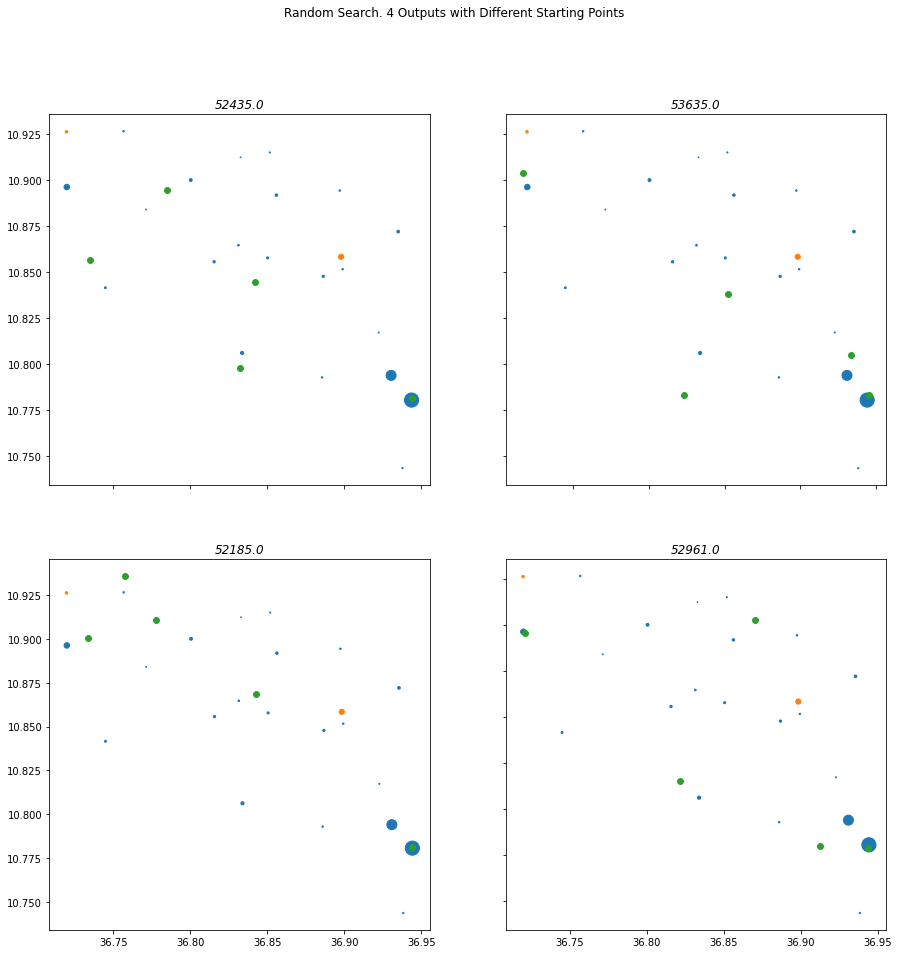

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx[i][1][1::2], fx[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [17]:
fx2 = [random_search(f2, 10000) for _ in range(4)]

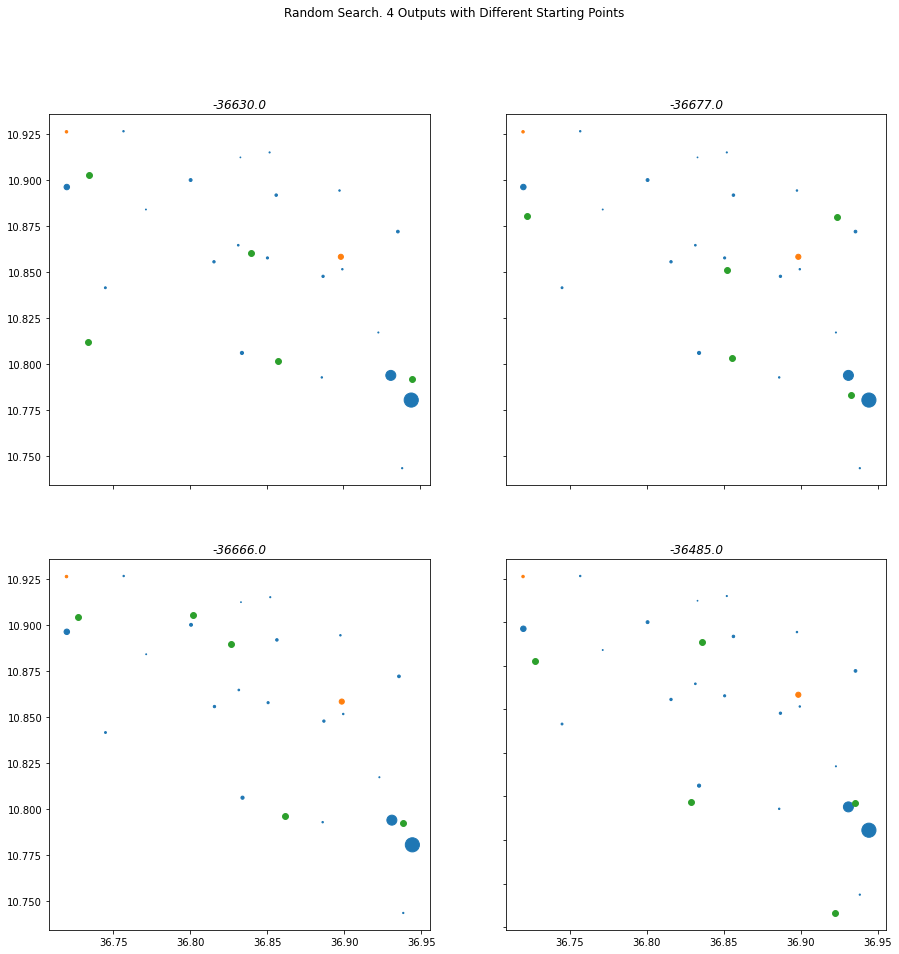

In [18]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Random Search F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fx2[i][1][1::2], fx2[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title(np.round(fx2[i][0],0), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

## CMA

In [36]:
sigmas = (0.01, 0.05, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24)
maxits = 10000

In [42]:
fcma = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0], j))
        
fcma_s = sorted(fcma, key=lambda t: t[0])[:4]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:09:43 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 3.184455730000000e+05 1.0e+00 9.48e-03  9e-03  1e-02 0:00.0
    2     20 3.147584620000000e+05 1.2e+00 1.01e-02  9e-03  1e-02 0:00.0
    3     30 2.905362500000000e+05 1.3e+00 1.08e-02  1e-02  1e-02 0:00.1
  100   1000 4.921797100000000e+04 1.8e+01 2.87e-03  3e-04  4e-03 0:00.8
  200   2000 4.512991900000000e+04 7.2e+01 2.16e-04  5e-06  3e-04 0:01.5
  300   3000 4.508787400000000e+04 3.9e+02 2.21e-05  2e-07  6e-05 0:02.0
  400   4000 4.508220200000000e+04 1.3e+03 8.75e-07  3e-09  4e-06 0:02.6
  500   5000 4.508217800000000e+04 1.0e+04 2.73e-07  3e-10  3e-06 0:03.1
NOTE (module=cma, iteration=500):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.0e+08 to 1.8e+01
  590   5900 4.508215300000000e+04 7.2e+00 1.34e-07  8e-11  1e-06 0:03.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=4

  300   3000 5.295027000000000e+04 6.8e+02 3.45e-04  2e-06  8e-04 0:01.7
  400   4000 5.294154100000000e+04 2.8e+03 8.27e-06  9e-09  2e-05 0:02.2
NOTE (module=cma, iteration=497):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.0e+08 to 1.4e+02
  500   5000 5.294152000000000e+04 1.1e+01 7.75e-07  2e-10  2e-06 0:02.7
  508   5080 5.294152000000000e+04 1.1e+01 5.46e-07  1e-10  1e-06 0:02.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:11:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.328237830000000e+05 1.0e+00 2.08e-01  2e-01  2e-01 0:00.0
    2     20 1.848089880000000e+05 1.1e+00 1.80e-01  2e-01  2e-01 0:00.0
    3     30 1.088377940000000e+05 1.2e+00 1.69e-01  2e-01  2e-01 0:00.0
  100   1000 6.606808500000001e+04 1.8e+01 6.56e-02  1e-02  1e-01 0:00.6
  200   2000 4.513005700000000e+04 3.4e+01 3.43e-04  1e-05  3e-04 0:01.1
  300   3000 4.508980000000000e+

    1     10 1.564703420000000e+05 1.0e+00 2.05e-01  2e-01  2e-01 0:00.0
    2     20 8.664309100000000e+04 1.2e+00 1.86e-01  2e-01  2e-01 0:00.0
    3     30 8.329528900000000e+04 1.2e+00 1.76e-01  2e-01  2e-01 0:00.0
  100   1000 5.488659500000000e+04 5.0e+00 1.18e-02  4e-03  1e-02 0:00.6
  200   2000 5.073143900000000e+04 3.5e+01 8.29e-04  4e-05  1e-03 0:01.2
  300   3000 5.062728400000000e+04 2.0e+02 1.82e-05  2e-07  3e-05 0:01.7
  400   4000 5.062637700000000e+04 1.2e+03 1.76e-07  4e-10  3e-07 0:02.2
  418   4180 5.062637600000000e+04 1.3e+03 1.06e-07  2e-10  2e-07 0:02.3
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:13:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.339398280000000e+05 1.0e+00 2.33e-01  2e-01  3e-01 0:00.0
    2     20 1.145287740000000e+05 1.2e+00 2.12e-01  2e-01  2e-01 0:00.0
    3     30 8.825150999999999e+04 1.2e+00 2.16e-01  2e-01  2e-01 0:00.0
  100   1000 6.525853500000000e+04 

    1     10 1.096051640000000e+05 1.0e+00 2.13e-01  2e-01  2e-01 0:00.0
    2     20 8.950959500000000e+04 1.2e+00 1.96e-01  2e-01  2e-01 0:00.0
    3     30 9.816233900000001e+04 1.2e+00 1.88e-01  2e-01  2e-01 0:00.0
  100   1000 5.813947000000000e+04 6.4e+00 2.94e-02  7e-03  3e-02 0:00.6
  200   2000 3.153819600000000e+04 2.8e+01 2.87e-03  1e-04  3e-03 0:01.1
  300   3000 2.855998900000000e+04 7.6e+01 1.81e-05  3e-07  2e-05 0:01.7
  400   4000 2.855574600000000e+04 1.1e+03 1.17e-05  6e-08  5e-05 0:02.2
  500   5000 2.855117400000000e+04 2.2e+03 5.66e-07  1e-09  2e-06 0:02.8
  536   5360 2.855116600000000e+04 3.7e+03 6.65e-08  1e-10  3e-07 0:03.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:14:00 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 1.132161740000000e+05 1.0e+00 2.16e-01  2e-01  2e-01 0:00.0
    2     20 1.424826350000000e+05 1.1e+00 2.00e-01  2e-01  2e-01 0:00.0
    3     30 8.719321000000001e+04 

In [46]:
fcma_s

[(22224.493,
  array([10.85355627, 36.83645597, 10.8963    , 36.7199    , 10.794     ,
         36.9308    , 10.90009999, 36.8005    , 10.7806    , 36.9441    ]),
  0.2),
 (24287.207,
  array([10.8963    , 36.7199    , 10.7806    , 36.9441    , 10.86469996,
         36.83149999, 10.794     , 36.9308    , 10.8721    , 36.9354    ]),
  0.16),
 (27446.88,
  array([10.8963    , 36.7199    , 10.86469998, 36.83150001, 10.7806    ,
         36.9441    , 10.94880691, 36.96243888, 10.794     , 36.9308    ]),
  0.14),
 (27446.88,
  array([10.76248729, 36.69341791, 10.794     , 36.9308    , 10.8647    ,
         36.8315    , 10.8963    , 36.7199    , 10.7806    , 36.9441    ]),
  0.12)]

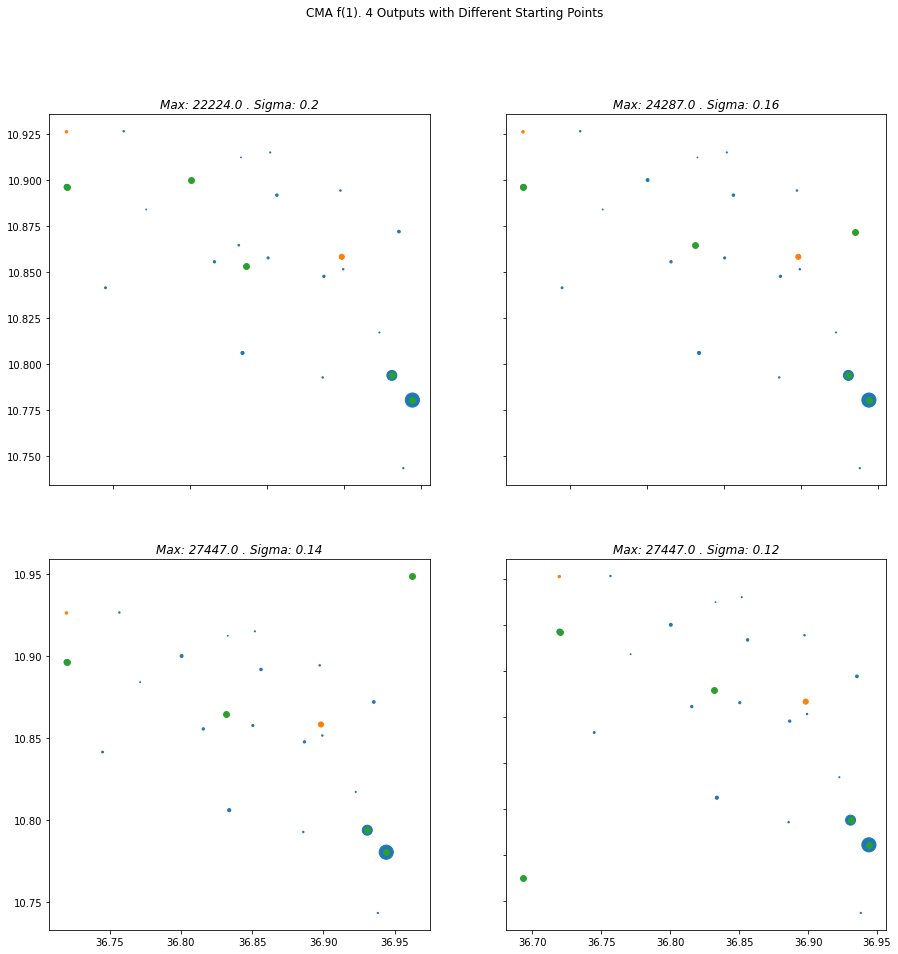

In [48]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA f(1). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma_s[i][1][1::2], fcma_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma_s[i][0],0))+ ' . Sigma: ' + str(fcma_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()

In [44]:
fcma2 = []

for i in range(4):
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(get_random_sp(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f2, iterations=maxits / es.popsize)
        fcma2.append((es.result[1], es.result[0], j))
        
fcma2_s = sorted(fcma2, key=lambda t: t[0])[:4]

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:15:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -1.932500000000000e+04 1.0e+00 9.59e-03  9e-03  1e-02 0:00.0
    2     20 -2.864300000000000e+04 1.2e+00 1.03e-02  1e-02  1e-02 0:00.0
    3     30 -2.938200000000000e+04 1.3e+00 1.08e-02  1e-02  1e-02 0:00.0
  100   1000 -3.750700000000000e+04 3.9e+00 2.87e-03  1e-03  3e-03 0:00.6
  200   2000 -3.754300000000000e+04 1.1e+01 3.21e-04  4e-05  3e-04 0:01.2
  300   3000 -3.754400000000000e+04 1.8e+01 4.98e-05  6e-06  3e-05 0:01.8
  325   3250 -3.754400000000000e+04 1.9e+01 4.91e-05  6e-06  3e-05 0:02.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:15:10 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -3.295200000000000e+04 1.0e+00 4.71e-02  4e-02  5e-02 0:00.0
    2     20 -3.221800000000000e+04 1.1e+00 4.38e-02  4e-02  5e-02 0:00.0
    3     

    2     20 -3.450900000000000e+04 1.2e+00 8.93e-02  8e-02  9e-02 0:00.0
    3     30 -2.838900000000000e+04 1.2e+00 8.65e-02  8e-02  9e-02 0:00.0
  100   1000 -3.498900000000000e+04 8.2e+00 1.17e-02  2e-03  2e-02 0:00.7
  200   2000 -3.499700000000000e+04 3.1e+01 5.46e-04  3e-05  6e-04 0:01.3
  268   2680 -3.499700000000000e+04 4.2e+01 1.71e-04  1e-05  2e-04 0:01.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:16:01 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.347500000000000e+04 1.0e+00 1.24e-01  1e-01  1e-01 0:00.0
    2     20 -2.854800000000000e+04 1.3e+00 1.30e-01  1e-01  1e-01 0:00.0
    3     30 -3.364500000000000e+04 1.3e+00 1.33e-01  1e-01  1e-01 0:00.0
  100   1000 -3.641400000000000e+04 6.9e+00 1.30e-02  3e-03  2e-02 0:00.6
  200   2000 -3.661800000000000e+04 1.0e+01 1.07e-03  2e-04  1e-03 0:01.1
  273   2730 -3.662200000000000e+04 2.4e+01 6.41e-05  6e-06  7e-05 0:01.5
(5_w,10)-aCMA-ES (mu_w=3

  100   1000 -3.627300000000000e+04 1.0e+01 2.51e-02  4e-03  3e-02 0:00.6
  200   2000 -3.659000000000000e+04 1.4e+01 2.40e-03  2e-04  2e-03 0:01.2
  300   3000 -3.661100000000000e+04 2.4e+01 1.14e-04  1e-05  1e-04 0:01.8
  361   3610 -3.661000000000000e+04 2.9e+01 4.13e-05  4e-06  3e-05 0:02.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:16:54 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.474100000000000e+04 1.0e+00 1.58e-01  2e-01  2e-01 0:00.0
    2     20 -1.851700000000000e+04 1.2e+00 1.35e-01  1e-01  1e-01 0:00.0
    3     30 -2.219900000000000e+04 1.3e+00 1.21e-01  1e-01  1e-01 0:00.0
  100   1000 -3.497300000000000e+04 8.0e+00 2.24e-02  6e-03  3e-02 0:00.6
  200   2000 -3.522400000000000e+04 2.1e+01 6.48e-04  8e-05  7e-04 0:01.2
  300   3000 -3.522600000000000e+04 3.4e+01 1.67e-04  1e-05  1e-04 0:01.8
  381   3810 -3.522500000000000e+04 7.4e+01 1.70e-04  1e-05  2e-04 0:02.3
(5_w,10)-aCMA-ES (mu_w=3

    2     20 -3.271100000000000e+04 1.2e+00 1.78e-01  2e-01  2e-01 0:00.0
    3     30 -5.482000000000000e+03 1.2e+00 1.67e-01  2e-01  2e-01 0:00.0
  100   1000 -3.667100000000000e+04 7.9e+00 1.48e-02  3e-03  1e-02 0:00.8
  200   2000 -3.698500000000000e+04 1.4e+01 2.14e-03  3e-04  2e-03 0:01.4
  300   3000 -3.698700000000000e+04 3.6e+01 2.62e-04  2e-05  2e-04 0:02.1
  358   3580 -3.698700000000000e+04 5.6e+01 2.26e-04  2e-05  2e-04 0:02.6
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Thu Jun 30 18:17:49 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -2.806500000000000e+04 1.0e+00 2.03e-01  2e-01  2e-01 0:00.0
    2     20 -3.319100000000000e+04 1.2e+00 1.94e-01  2e-01  2e-01 0:00.0
    3     30 -2.513400000000000e+04 1.3e+00 1.79e-01  2e-01  2e-01 0:00.0
  100   1000 -3.672600000000000e+04 8.2e+00 1.32e-02  3e-03  1e-02 0:00.7
  200   2000 -3.698700000000000e+04 1.2e+01 1.07e-03  2e-04  1e-03 0:01.4
  300   3000 -3.69880000

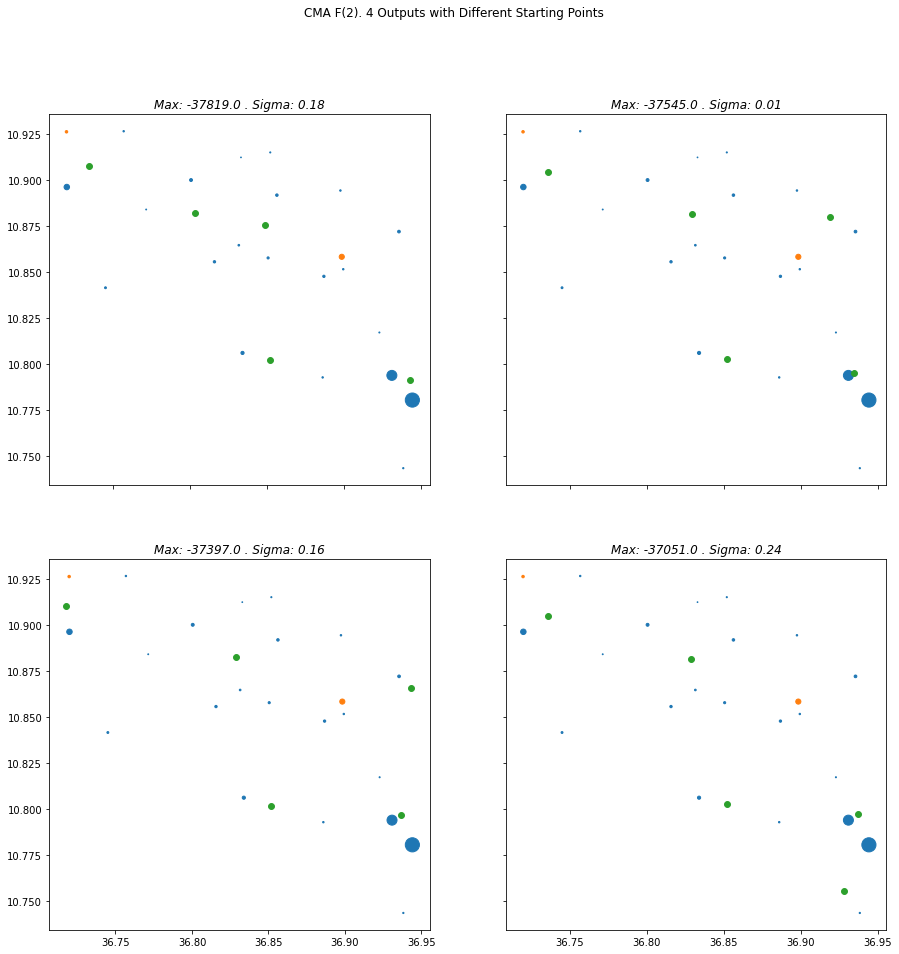

In [49]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('CMA F(2). 4 Outputs with Different Starting Points')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter(fcma2_s[i][1][1::2], fcma2_s[i][1][::2], s = 35, marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title('Max: ' + str(np.round(fcma2_s[i][0],0))+ ' . Sigma: ' + str(fcma2_s[i][2]), fontstyle='italic')

for ax in fig.get_axes():
    ax.label_outer()